# RIDIR Scaling an inference framework for specific measures

In [27]:
import numpy as np
import pandas as pd
import warnings
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Concentration Profile Function

In [2]:
"""
Concentration Profile based Segregation Metrics
"""

__author__ = "Renan X. Cortes <renanc@ucr.edu> and Sergio J. Rey <sergio.rey@ucr.edu>"

import numpy as np
import pandas as pd
import warnings

__all__ = ['ConProf']


def _conprof(data, group_pop_var, total_pop_var, m = 1000):
    """
    Calculation of Concentration Profile

    Parameters
    ----------

    data          : a pandas DataFrame
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit
                    
    m             : int
                    a numeric value indicating the number of thresholds to be used. Default value is 1000. 
                    A large value of m creates a smoother-looking graph and a more precise concentration profile value but slows down the calculation speed.

    Attributes
    ----------

    statistic : float
                Concentration Profile Index

    Notes
    -----
    Hong, Seong-Yun, and Yukio Sadahiro. "Measuring geographic segregation: a graph-based approach." Journal of Geographical Systems 16.2 (2014): 211-231.

    """
    if(type(m) is not int):
        raise TypeError('m must be a string.')
        
    if(m < 2):
        raise ValueError('m must be greater than 1.')
    
    if((type(group_pop_var) is not str) or (type(total_pop_var) is not str)):
        raise TypeError('group_pop_var and total_pop_var must be strings')
    
    if ((group_pop_var not in data.columns) or (total_pop_var not in data.columns)):    
        raise ValueError('group_pop_var and total_pop_var must be variables of data')

    data = data.rename(columns={group_pop_var: 'group_pop_var', 
                                total_pop_var: 'total_pop_var'})
    
    if any(data.total_pop_var < data.group_pop_var):    
        raise ValueError('Group of interest population must equal or lower than the total population of the units.')
   
    def calculate_vt(t):
        g_t_i = np.where(data.group_pop_var / data.total_pop_var >= t, 1, 0)
        v_t = (g_t_i * data.group_pop_var).sum() / data.group_pop_var.sum()
        return v_t
    
    grid = np.linspace(0, 1, m)
    curve = np.array(list(map(calculate_vt, grid)))
    
    threshold = data.group_pop_var.sum() / data.total_pop_var.sum()
    R = ((threshold - ((curve[grid < threshold]).sum() / m - (curve[grid >= threshold]).sum()/ m)) / (1 - threshold))
    
    return R, grid, curve


class ConProf:
    """
    Concentration Profile Index

    Parameters
    ----------

    data          : a pandas DataFrame
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit
                    
    m             : int
                    a numeric value indicating the number of thresholds to be used. 
                    A large value of m creates a smoother-looking graph and a more precise concentration profile value but slows down the calculation speed.

    Attributes
    ----------

    statistic : float
                Concentration Profile Index
        
    Examples
    --------
    In this example, we will calculate the concentration profile (R) for the Riverside County using the census tract data of 2010.
    The group of interest is non-hispanic black people which is the variable nhblk10 in the dataset.
    
    Firstly, we need to read the data:
    
    >>> url = 'https://raw.githubusercontent.com/renanxcortes/inequality-segregation-supplementary-files/master/data/std_2010_fullcount.csv'
    >>> census_2010 = pd.read_csv(url, encoding = "ISO-8859-1", sep = ",")
    
    Then, we filter only for the desired county (in this case, Riverside County):
    
    >>> df = census_2010.loc[census_2010.county == "Riverside County"][['pop10','nhblk10']]
    
    The value is estimated below.
    
    >>> conprof_index = ConProf(df, 'nhblk10', 'pop10')
    >>> conprof_index.statistic
    0.06393365660089256
    
    You can plot the profile curve with the plot method.
    
    >>> conprof_index.plot()
        
    Notes
    -----
    Based on Massey, Douglas S., and Nancy A. Denton. "The dimensions of residential segregation." Social forces 67.2 (1988): 281-315.

    """

    def __init__(self, data, group_pop_var, total_pop_var, m = 1000):

        self.statistic = _conprof(data, group_pop_var, total_pop_var, m)[0]
        self.grid      = _conprof(data, group_pop_var, total_pop_var, m)[1]
        self.curve     = _conprof(data, group_pop_var, total_pop_var, m)[2]

    def plot(self):
        """
        Plot the Concentration Profile
        """
        try:
            import matplotlib.pyplot as plt
        except ImportError:
            warnings.warn('This method relies on importing `matplotlib`')
        graph = plt.scatter(self.grid, self.curve, s = 0.1)
        return graph

## Modified Dissimilarity Index Function

In [4]:
"""
Modified Dissimilarity based Segregation Metrics
"""

__author__ = "Renan X. Cortes <renanc@ucr.edu> and Sergio J. Rey <sergio.rey@ucr.edu>"

import numpy as np
import pandas as pd
from dissimilarity import _dissim

__all__ = ['Modified_Dissim']


def _modified_dissim(data, group_pop_var, total_pop_var, iterations = 500):
    """
    Calculation of Modified Dissimilarity index

    Parameters
    ----------

    data          : a pandas DataFrame
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit
                    
    iterations    : int
                    The number of iterations the evaluate average classic dissimilarity under eveness. Default value is 500.

    Attributes
    ----------

    statistic : float
                Modified Dissimilarity Index (Dissimilarity from Carrington and Troske (1997))

    Notes
    -----
    Based on Carrington, William J., and Kenneth R. Troske. "On measuring segregation in samples with small units." Journal of Business & Economic Statistics 15.4 (1997): 402-409.

    """
    if(type(iterations) is not int):
        raise TypeError('iterations must be an integer')
        
    if(iterations < 2):
        raise TypeError('iterations must be greater than 1.')
   
    D = _dissim(data, group_pop_var, total_pop_var)
    
    data = data.rename(columns={group_pop_var: 'group_pop_var', 
                                total_pop_var: 'total_pop_var'})
    
    p_null = data.group_pop_var.sum() / data.total_pop_var.sum()
    
    
    
    Ds = np.empty(iterations)
    
    for i in np.array(range(iterations)):

        freq_sim = np.random.binomial(n = np.array([data.total_pop_var.tolist()]), 
                                      p = np.array([[p_null] * data.shape[0]]), 
                                      size = (1, data.shape[0])).tolist()[0]
        data = data.assign(group_pop_var = freq_sim)
        aux = _dissim(data, 'group_pop_var', 'total_pop_var')
        Ds[i] = aux
        
    D_star = Ds.mean()
    
    if (D >= D_star):
        Dct = (D - D_star)/(1 - D_star)
    else:
        Dct = (D - D_star)/D_star
        
    return Dct


class Modified_Dissim:
    """
    Calculation of Modified Dissimilarity index

    Parameters
    ----------

    data          : a pandas DataFrame
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit
                    
    iterations    : int
                    The number of iterations the evaluate average classic dissimilarity under eveness. Default value is 500.

    Attributes
    ----------

    statistic : float
                Modified Dissimilarity Index (Dissimilarity from Carrington and Troske (1997))
        
    Examples
    --------
    In this example, we will calculate the Modified Dissimilarity Index (Dct) for the Riverside County using the census tract data of 2010.
    The group of interest is non-hispanic black people which is the variable nhblk10 in the dataset.
    
    Firstly, we need to read the data:
    
    >>> url = 'https://raw.githubusercontent.com/renanxcortes/inequality-segregation-supplementary-files/master/data/std_2010_fullcount.csv'
    >>> census_2010 = pd.read_csv(url, encoding = "ISO-8859-1", sep = ",")
    
    Then, we filter only for the desired county (in this case, Riverside County):
    
    >>> df = census_2010.loc[census_2010.county == "Riverside County"][['pop10','nhblk10']]
    
    The value is estimated below.
    
    >>> np.random.seed(1234)
    >>> modified_dissim_index = Modified_Dissim(df, 'nhblk10', 'pop10')
    >>> modified_dissim_index.statistic
    0.30009504639081996
     
    Notes
    -----
    Based on Carrington, William J., and Kenneth R. Troske. "On measuring segregation in samples with small units." Journal of Business & Economic Statistics 15.4 (1997): 402-409.

    """

    def __init__(self, data, group_pop_var, total_pop_var, iterations = 500):

        self.statistic = _modified_dissim(data, group_pop_var, total_pop_var, iterations)
        

# Calculate both measures

In [18]:
def calculate_segregation(data, group_pop_var, total_pop_var, iterations = 500, m = 1000):
    '''
    data: a geopandas DataFrame that contains a geometry column
    group_pop_var: the name of variable that contains the population size of the group of interest
    total_pop_var: the name of variable that contains the total population of the unit
    iterations    : int
                    The number of iterations the evaluate average classic dissimilarity under eveness. Default value is 500.
    m: a numeric value indicating the number of thresholds to be used in the Concentration Profile Index
    '''
    
    CP = ConProf(data, group_pop_var, total_pop_var, m = m).statistic
    MD = Modified_Dissim(data, group_pop_var, total_pop_var, iterations = iterations).statistic
    
    return {'Concentration Profile (CP)': CP, 
            'Modified Dissimilarity (MD)': MD
           }

## Compare Segregation Function

In [19]:
def compare_segregation(stacked_data, 
                        group_pop_var, 
                        total_pop_var,
                        grouping_variable,
                        iterations = 1000,
                        null_approach = "random_spatial"):
    '''
    stacked_data      : a geopandas DataFrame that contains a geometry column and a grouping variable
    group_pop_var     : the name of variable that contains the population size of the group of interest
    total_pop_var     : the name of variable that contains the total population of the unit
    grouping_variable : name of the grouping variable that contains the label of each unit. This can be either a region label or a time period label.
    iterations        : number of iterations to compute inference on pseudo p-values
    null_approach     : argument that specifies which type of null hyphotesis the inference will iterate. 
        "random_spatial" : randomly allocates the geometry
        "random_data"    : randomly allocates the data
    '''
    
    stacked_data = stacked_data.rename(columns={group_pop_var: 'group_pop_var', 
                                                total_pop_var: 'total_pop_var',
                                                grouping_variable: 'grouping_variable'})
    
    label_A = list(set(stacked_data.grouping_variable))[0]
    label_B = list(set(stacked_data.grouping_variable))[1]
    
    CPs  = np.empty(iterations)
    MDs  = np.empty(iterations)
             

    if (null_approach == "random_spatial"):
        for i in np.array(range(iterations)):
            
            aux_rand = list(np.random.choice(stacked_data.shape[0], stacked_data.shape[0], replace = False))

            stacked_data['rand_grouping'] = stacked_data.grouping_variable[aux_rand].reset_index()['grouping_variable']
            
            stacked_data_A = stacked_data.loc[stacked_data['rand_grouping'] == label_A]
            stacked_data_B = stacked_data.loc[stacked_data['rand_grouping'] == label_B]

            simulations_A =  calculate_segregation(stacked_data_A, 'group_pop_var', 'total_pop_var')
            simulations_B =  calculate_segregation(stacked_data_B, 'group_pop_var', 'total_pop_var')

            CPs[i] = list(simulations_A.values())[0] - list(simulations_B.values())[0]
            MDs[i] = list(simulations_A.values())[1] - list(simulations_B.values())[1]
            
    if (null_approach == "random_data"):
        for i in np.array(range(iterations)):
            
            aux_rand = list(np.random.choice(stacked_data.shape[0], stacked_data.shape[0], replace = False))

            stacked_data['rand_group_pop'] = stacked_data.group_pop_var[aux_rand].reset_index()['group_pop_var']
            stacked_data['rand_total_pop'] = stacked_data.total_pop_var[aux_rand].reset_index()['total_pop_var']
            
            # Dropping variable to avoid confusion in the calculate_segregation function 
            # Building auxiliar data to avoid affecting the next iteration
            stacked_data_aux = stacked_data.drop(['group_pop_var', 'total_pop_var'], axis = 1)
            
            stacked_data_A = stacked_data_aux.loc[stacked_data_aux['grouping_variable'] == label_A]
            stacked_data_B = stacked_data_aux.loc[stacked_data_aux['grouping_variable'] == label_B]

            simulations_A =  calculate_segregation(stacked_data_A, 'rand_group_pop', 'rand_total_pop')
            simulations_B =  calculate_segregation(stacked_data_B, 'rand_group_pop', 'rand_total_pop')

            CPs[i] = list(simulations_A.values())[0] - list(simulations_B.values())[0]
            MDs[i] = list(simulations_A.values())[1] - list(simulations_B.values())[1]
    
    
    return CPs, MDs

## Comparing Riverside to itself between 2000 and 2010

In [20]:
import os
os.chdir('C:/Users/renan/Desktop/inequality-segregation-supplementary-files/')

census_2010 = pd.read_csv("data/std_2010_fullcount.csv", encoding = "ISO-8859-1", sep = ",")
census_2000 = pd.read_csv("data/std_2000_fullcount.csv", encoding = "ISO-8859-1", sep = ",")

# Some population data for 2000 came as decimals
census_2000['pop00']   = round(census_2000['pop00']).astype(int)
census_2000['nhblk00'] = round(census_2000['nhblk00']).astype(int)

map_gpd = gpd.read_file('Tracts_grouped_by_County/06065.json')

map_gpd['INTGEOID10'] = pd.to_numeric(map_gpd["GEOID10"])

df_map1 = map_gpd.merge(census_2000, left_on = 'INTGEOID10', right_on = 'trtid10')[['geometry', 'nhblk00', 'pop00']]
df_map2 = map_gpd.merge(census_2010, left_on = 'INTGEOID10', right_on = 'trtid10')[['geometry', 'nhblk10', 'pop10']]

df_map1['rel'] = np.where(df_map1['pop'] == 0, 0, df_map1['nhblk']/df_map1['pop'])
df_map2['rel'] = np.where(df_map2['pop'] == 0, 0, df_map2['nhblk']/df_map2['pop'])

actual_values_A = calculate_segregation(df_map1, 'nhblk00', 'pop00')
actual_values_B = calculate_segregation(df_map2, 'nhblk10', 'pop10')

df_map1['year'] = '1'
df_map2['year'] = '2'

df_map1 = df_map1.rename(index=str, columns={'nhblk00': 'nhblk', 'pop00': 'pop'})
df_map2 = df_map2.rename(index=str, columns={'nhblk10': 'nhblk', 'pop10': 'pop'})

stacked_df_map = pd.concat([df_map1, df_map2], ignore_index=True)

In [21]:
calculate_segregation(df_map1, 'nhblk', 'pop')

{'Concentration Profile (CP)': 0.08648414019460181,
 'Modified Dissimilarity (MD)': 0.3849376130100682}

KeyError: 'rel'

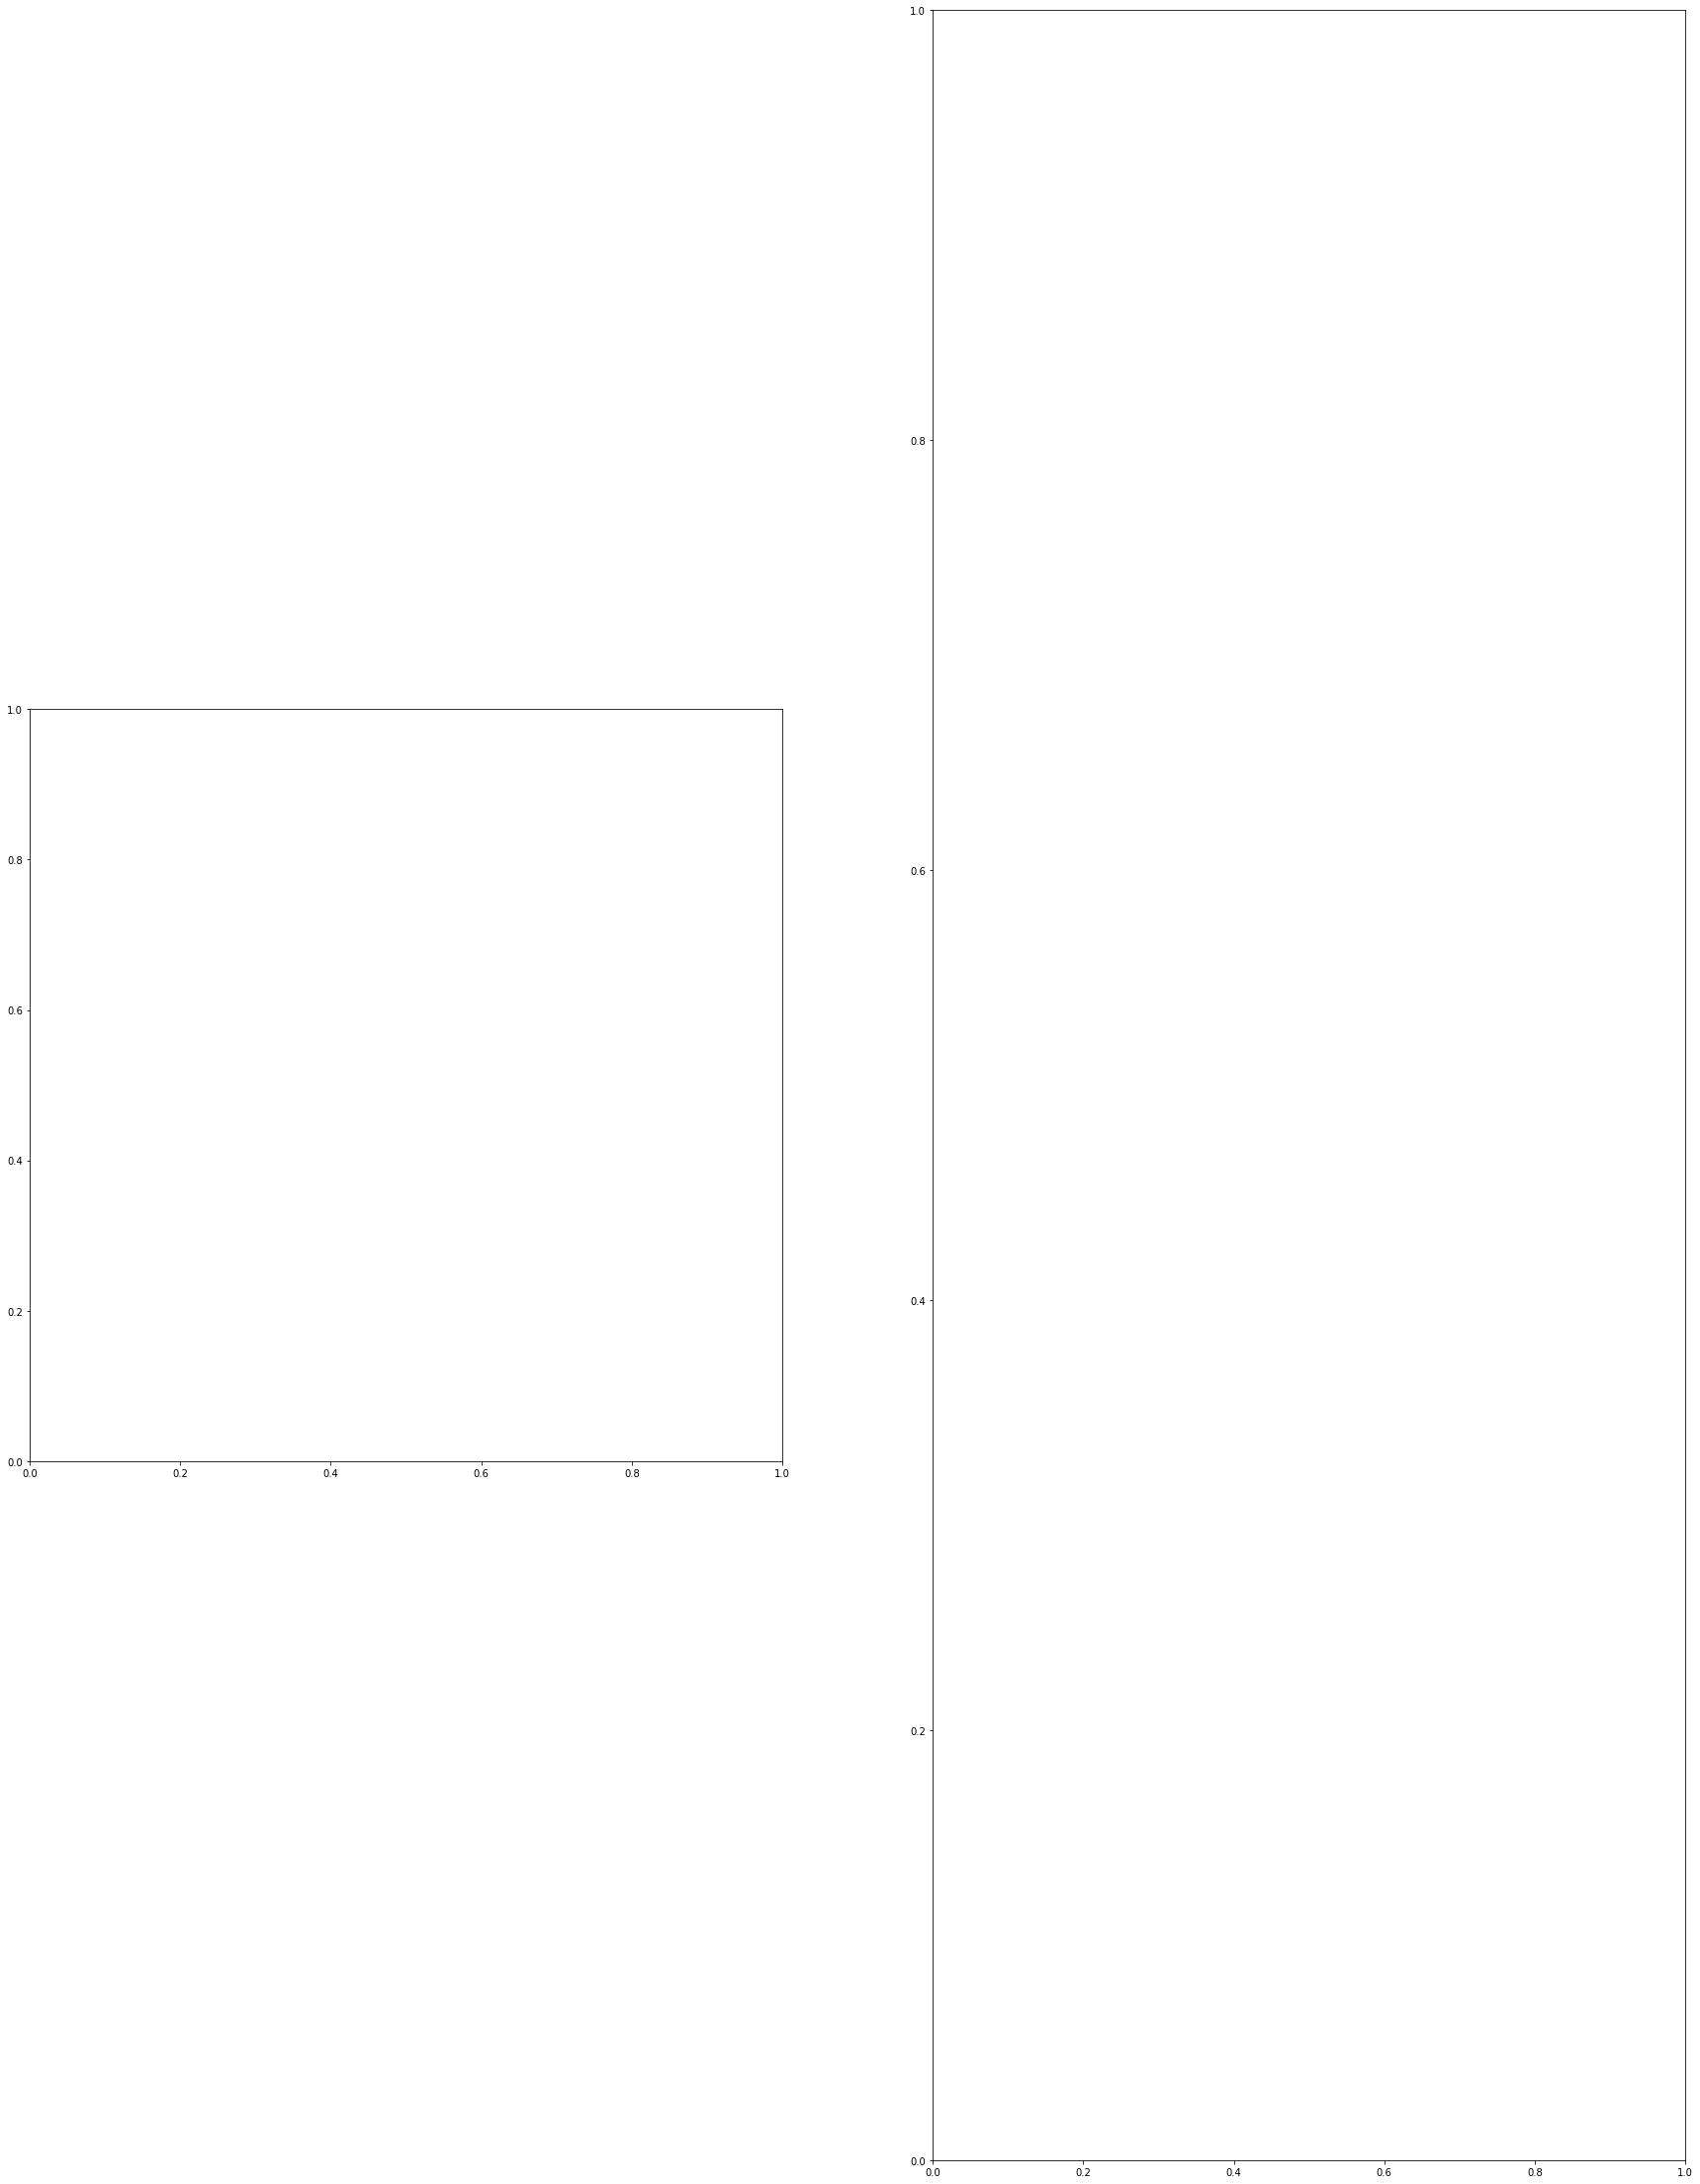

In [29]:
# Two subplots
f, axarr = plt.subplots(1, 2, figsize=(30, 40))
ax1 = df_map1.plot(column='rel',
                   cmap = 'OrRd', 
                   ax=axarr[0])

ax2 = df_map2.plot(column='rel',
                   cmap = 'OrRd', 
                   ax=axarr[1])

In [25]:
simulations = compare_segregation(stacked_df_map, 
                                  'nhblk', 
                                  'pop',
                                  'year',
                                  iterations = 5, # !
                                  null_approach = "random_data")

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


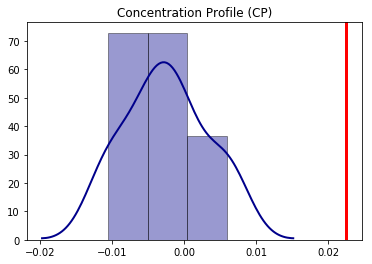

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


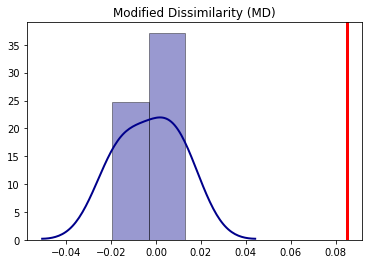

In [28]:
for i in range(len(simulations)):
    sns.distplot(simulations[i], 
                 hist=True, 
                 color = 'darkblue', 
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 2})
    #plt.axvline(0, color = 'green')
    plt.axvline(list(actual_values_A.values())[i] - list(actual_values_B.values())[i], color = 'red', linewidth = 3)
    plt.title(list(actual_values_A.keys())[i])
    plt.show()